# Import Necessary Package

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt  
import pandas as pd

# Load Training Data

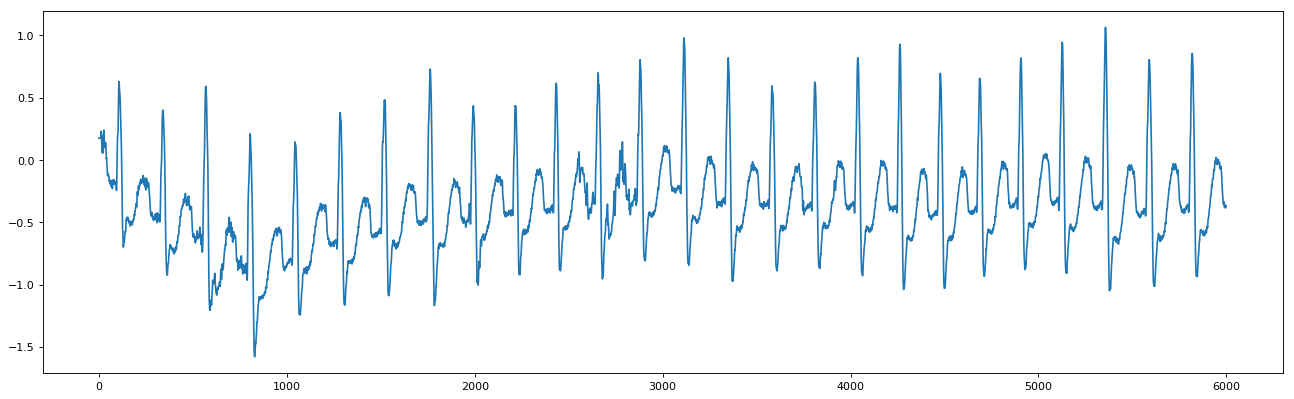

In [4]:
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', 
       '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']

trainingSet = {}

for ds in DS1:
    dataSetLoc = 'D:/Data/Data/DS1/MIT-BIH Arrhythmia' + ds + '_mitdb' + ds + '/' + ds
    record = wfdb.rdsamp(dataSetLoc)
    lead0 = record.p_signals[:,0]
    lead1 = record.p_signals[:,1]
    annotation = wfdb.rdann(dataSetLoc, 'atr')
    annIdx = annotation.sample
    annType = annotation.symbol
    trainingSet[ds] = {'lead0': lead0, 'lead1': lead1, 'annIdx': annIdx, 'annType': annType}
    
# 测试数据集的读取情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(trainingSet['109']['lead0'][:6000])
temp1 = trainingSet['109']['lead0'][:6000]
plt.show()

# Data Denoising

## Baseline Wander Removal

In [5]:
for k, v in trainingSet.items():
    first_filtered = medfilt(v['lead0'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead0'] = v['lead0'] - second_filtered

    first_filtered = medfilt(v['lead1'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead1'] = v['lead1'] - second_filtered

# 测试数据集的去噪情况



In [14]:
plt.figure(figsize=(20, 6), dpi=300)
plt.plot(temp1, label = 'ECG signal with baseline wandering')
plt.plot(trainingSet['109']['lead0'][:6000], label = 'Signal with removed baseline wandering')

temp2 = trainingSet['109']['lead0'][:6000]
plt.legend()
#plt.show()
plt.savefig('C:/Users/Sam/Desktop/1.jpg')

## High Frequency Noise Removal in Use of Wavelets Transformation

In [4]:
def wt(index_list,wavefunc,lv,m,n):   # 打包为函数，方便调节参数。  lv为分解层数；index_list为待处理序列；wavefunc为选取的小波函数；m,n则选择了进行阈值处理的小波系数层数
   
    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数

    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  # 计算阈值
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) - Tr  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零

    # 重构
    denoised_index = pywt.waverec(coeff,wavefunc)
    return denoised_index

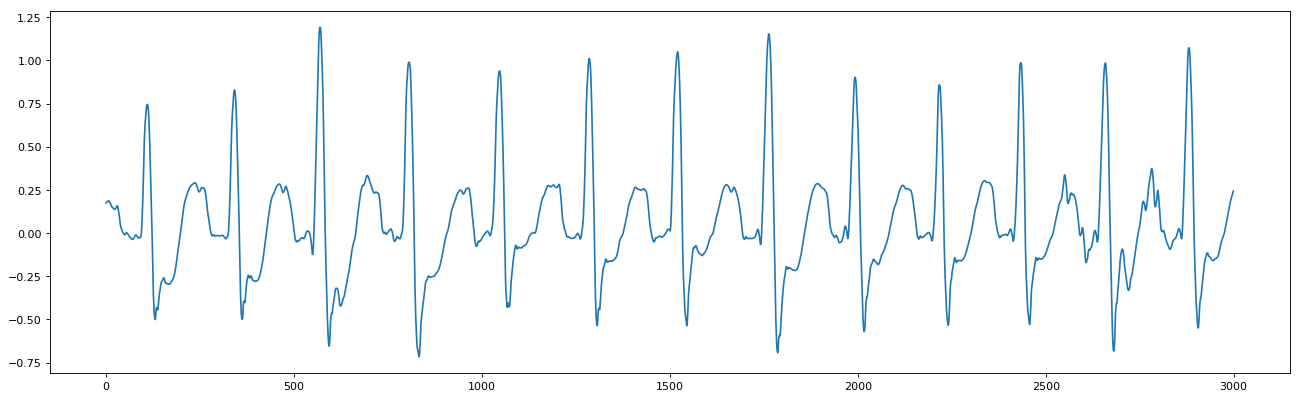

In [5]:
for k, v in trainingSet.items():
    v['lead0'] = wt(v['lead0'],'db4',4,2,4)
    v['lead1'] = wt(v['lead1'],'db4',4,2,4)

# 测试数据集的去噪情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(trainingSet['109']['lead0'][:3000])
temp3 = trainingSet['109']['lead0'][:3000]
plt.show()

# Comparison before and after Preprocessing

In [16]:
plt.figure(figsize=(20, 15), dpi=80)
p1 = plt.subplot(311)
p1.set_title('Original signal')
p2 = plt.subplot(312)
p2.set_title('After baseline wandering removal')
p3 = plt.subplot(313)
p3.set_title('After noise reduction')

plt.subplots_adjust(wspace =0, hspace =0.3)

p1.plot(temp1[:2000])
p2.plot(temp2[:2000])
p3.plot(temp3[:2000])

#plt.show()
plt.savefig('preprocessing')

# Save Cleaned Data to CSV

In [52]:
headers = ['lead0', 'lead1', 'annIdx', 'annType']

for k, v in trainingSet.items():
    df1 = pd.DataFrame({ 'lead0': trainingSet[k]['lead0'], 'lead1': trainingSet[k]['lead1']})
    df1.to_csv('Cleaned TrainingSet/' + k + '_lead.csv', index=False)
    
    df2 = pd.DataFrame({ 'annIdx': trainingSet[k]['annIdx'], 'annType': trainingSet[k]['annType']})
    df2.to_csv('Cleaned TrainingSet/' + k + '_ann.csv', index=False)

In [56]:
# 测试存储情况
df_lead = pd.read_csv('Cleaned TrainingSet/109_lead.csv')
df_ann = pd.read_csv('Cleaned TrainingSet/109_ann.csv')
df_lead
df_ann

,annIdx,annType
0,18,+
1,111,L
2,343,L
3,571,L
4,807,L
5,1048,L
6,1287,L
7,1523,L
8,1765,L
9,1994,L


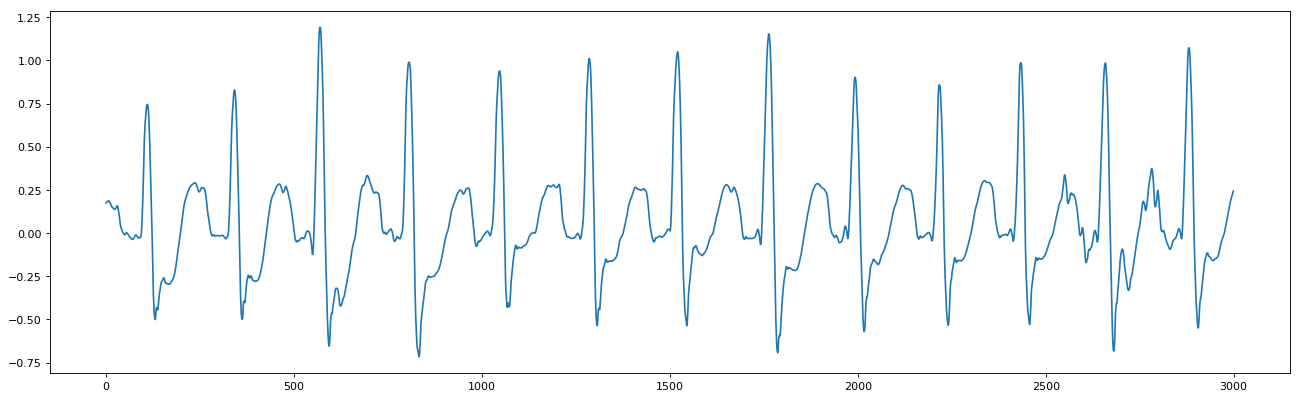

In [57]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(df_lead['lead0'][:3000])
plt.show()